# faab-run-loop


In [1]:
import torch 
from pybela import Streamer
import json
import asyncio
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os 

from utils import get_device, load_config, load_model, get_all_run_ids, load_train_loss

device = get_device()

path ="models/trained"

## run-loop testing

In [3]:
vars = ['gFaabSensor_1', 'gFaabSensor_2', 'gFaabSensor_3', 'gFaabSensor_4', 'gFaabSensor_5', 'gFaabSensor_6', 'gFaabSensor_7', 'gFaabSensor_8']
streamer = Streamer()
streamer.connect()

Connection successful


1

In [ ]:
_id = "02emtq9d"
model = load_model(_id, path=path)
seq_len = 512

async def callback(block):
    _raw_data_tensor = torch.stack([torch.FloatTensor(buffer["buffer"]["data"]) for buffer in block]) # num_features, 1024
    inputs = _raw_data_tensor.unfold(1, seq_len, seq_len).permute(1,2,0) # n, seq_len, num_features  
    
    for _input in inputs:
        out = model(_input.to(device)).permute(1,0) # num_features, seq_len
        for idx,feature in enumerate(out):
            streamer.send_buffer(idx, 'f', seq_len, feature.tolist(), verbose=True)
            
streamer.start_streaming(vars, on_block_callback=callback)
asyncio.run(asyncio.sleep(10))
streamer.stop_streaming()



## models params

In [4]:
run_ids = get_all_run_ids(path=path)
params = ["ff_size", "num_heads", "num_layers", "learning_rate"]
_id_config = {}

for _id in run_ids:
    _id_config[_id] = {key: load_config(_id, path=path)[key] for key in params}
    
df = pd.DataFrame.from_dict(_id_config, orient='index')
df.head(10)    

,ff_size,num_heads,num_layers,learning_rate
abor4fs6,32,2,1,0.000516
qcamd717,256,2,8,0.000112
3r3rbr3q,256,1,7,0.000168
ggnxfugo,256,1,7,0.000842
qba7ejlo,16,4,3,0.000149
2kqwwsar,128,4,6,0.000466
ejdzc3ym,64,2,7,0.000850
24jf630m,64,4,7,0.000105
jeixb37n,8,4,6,0.000838
u0ahkjvo,32,4,7,0.000797


### scale to values between 0 and 1

In [5]:
ranges = {
    "ff_size": [8, 16, 32, 64, 128, 256],
    "num_heads": [1, 2, 4],
    "num_layers": [1, 2, 3, 4, 5, 6, 7, 8]
}

mapped_ranges = {}
for key in ranges:
    mapped_ranges[key] = {value: idx /(len(ranges[key])-1) for idx, value in enumerate(ranges[key])}

ranges, mapped_ranges

({'ff_size': [8, 16, 32, 64, 128, 256],
  'num_heads': [1, 2, 4],
  'num_layers': [1, 2, 3, 4, 5, 6, 7, 8]},
 {'ff_size': {8: 0.0, 16: 0.2, 32: 0.4, 64: 0.6, 128: 0.8, 256: 1.0},
  'num_heads': {1: 0.0, 2: 0.5, 4: 1.0},
  'num_layers': {1: 0.0,
   2: 0.14285714285714285,
   3: 0.2857142857142857,
   4: 0.42857142857142855,
   5: 0.5714285714285714,
   6: 0.7142857142857143,
   7: 0.8571428571428571,
   8: 1.0}})

In [6]:
column_functions = {
    "ff_size": lambda x: mapped_ranges["ff_size"][x],
    "num_heads": lambda x: mapped_ranges["num_heads"][x],
    "num_layers": lambda x:mapped_ranges["num_layers"][x],
    "learning_rate": lambda x: x*1000
}


# Apply a different function to each column
df_scaled = df.copy()
for column, func in column_functions.items():
    if column in df_scaled.columns:
        df_scaled[column] = df_scaled[column].apply(func)
        
df_scaled.head(10)

,ff_size,num_heads,num_layers,learning_rate
abor4fs6,0.4,0.5,0.000000,0.516246
qcamd717,1.0,0.5,1.000000,0.112486
3r3rbr3q,1.0,0.0,0.857143,0.168206
ggnxfugo,1.0,0.0,0.857143,0.841713
qba7ejlo,0.2,1.0,0.285714,0.149064
2kqwwsar,0.8,1.0,0.714286,0.465967
ejdzc3ym,0.6,0.5,0.857143,0.849721
24jf630m,0.6,1.0,0.857143,0.105182
jeixb37n,0.0,1.0,0.714286,0.837599
u0ahkjvo,0.4,1.0,0.857143,0.797156


In [ ]:
scaled_model_coordinates = df_scaled.to_numpy()
scaled_model_coordinates.shape

In [ ]:
from utils import get_scaled_params
scaled_model_coordinates = get_scaled_params()

In [ ]:
from utils import find_closest_model
import numpy as np
vector = np.array([0.1, 0.2, 0.3, 0.4])  # Replace with your actual vector

find_closest_model(vector, scaled_model_coordinates)

In [ ]:
list(scaled_model_coordinates.values())

test the scaling (assumes model output to be between 0 and 1)

In [ ]:
vector = np.array([0.1, 0.2, 0.3, 0.4])  # Replace with your actual vector

# Calculate the Euclidean distances
distances = np.linalg.norm(scaled_model_coordinates - vector, axis=1)

# Find the index of the row with the smallest distance
closest_row_index = np.argmin(distances)

# Closest row
closest_row = scaled_model_coordinates[closest_row_index]

print(closest_row)

In [ ]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(df_scaled.columns):
    sns.histplot(df_scaled[column], ax=axes[i])
    axes[i].set_title(f'Distribution of Values for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide any unused axes if the number of columns is odd
if len(df_scaled.columns) % 2 != 0:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
for _id in run_ids:
    _id_config[_id] = {key: load_config(_id, path=path)[key] for key in params}
    
df = pd.DataFrame.from_dict(_id_config, orient='index')
df.head(10)   

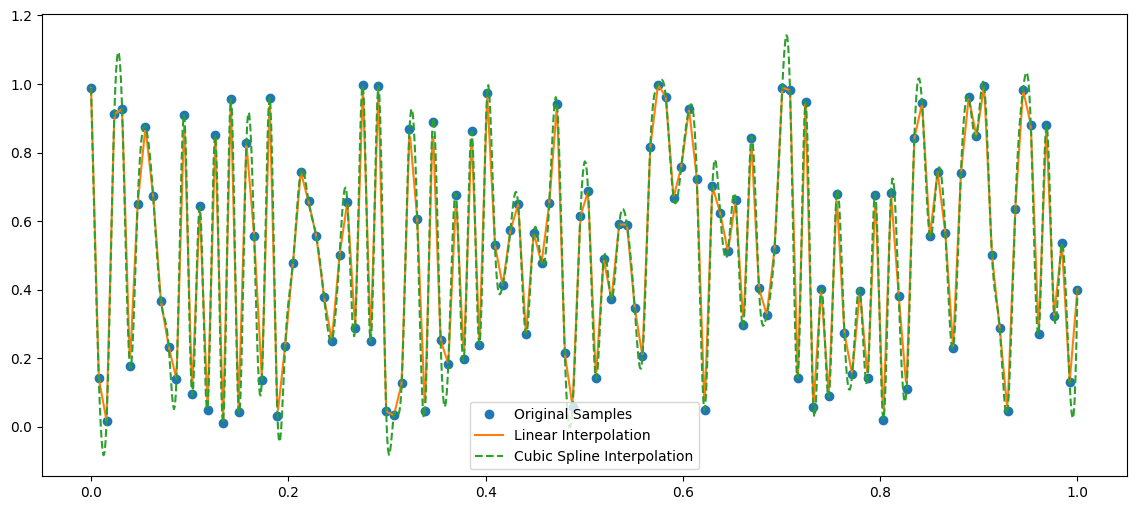

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Original sequence of 128 samples
original_sequence = np.random.rand(128)  # Example sequence

# Original indices
original_indices = np.linspace(0, 1, num=128)

# New indices for the interpolated sequence
new_indices = np.linspace(0, 1, num=1024)

# Linear interpolation
linear_interpolator = interp1d(original_indices, original_sequence)
linear_interpolated_sequence = linear_interpolator(new_indices)

# Spline interpolation for smoother results
spline_interpolator = interp1d(original_indices, original_sequence, kind='cubic')
spline_interpolated_sequence = spline_interpolator(new_indices)

# Plotting the results for comparison
plt.figure(figsize=(14, 6))
plt.plot(original_indices, original_sequence, 'o', label='Original Samples')
plt.plot(new_indices, linear_interpolated_sequence, '-', label='Linear Interpolation')
plt.plot(new_indices, spline_interpolated_sequence, '--', label='Cubic Spline Interpolation')
plt.legend()
plt.show()